In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from proposed.model.DepthNet import DepthNet
from proposed.train_dataset import TrainDataset
from proposed_grid.train_dataset import TrainDataset as GridDataset
from raw_data.utils import image_torch2np
from raw_data.utils import depth_torch2np

In [2]:
def compute_metrics(pred_depth: np.ndarray, depth: np.ndarray, min_depth: float, max_depth: float) -> dict[str, float]:
    pred_depth # shape = (H_pred, W_pred)
    depth # shape = (H_depth, W_depth)

    # Resize pred_depth to match depth size
    if pred_depth.shape != depth.shape:
        pred_depth = skimage.transform.resize(pred_depth, depth.shape, order=0)
    
    # Consider only valid pixels
    valid = (depth > 0)
    if not valid.any():
        raise ValueError("No valid pixels in the ground-truth depth map")
    
    pred_valid = (pred_depth > 0)
    if not pred_valid.any():
        raise ValueError("No valid pixels in the predicted depth map")
    
    val_percentage = ((~pred_valid) & valid).mean()
    mask = valid & pred_valid
    if not mask.any():
        raise ValueError("No valid pixels corresponding both to ground-truth and predicted depth maps")
    
    depth = depth[mask].reshape(-1) # shape = (num_valid_pixels,)
    pred_depth = pred_depth[mask].reshape(-1) # shape = (num_valid_pixels,)

    # Clamp prediction and ground truth
    depth = depth.clip(min_depth, max_depth)
    pred_depth = pred_depth.clip(min_depth, max_depth)

    # Compute accuracy metrics
    thresh = np.max(np.stack([(depth / pred_depth), (pred_depth / depth)], axis=0), axis=0)
    mask_a1 = (thresh < 1.25)
    mask_a2 = (thresh < 1.25 ** 2)
    mask_a3 = (thresh < 1.25 ** 3)
    a1 = (mask_a1.mean(dtype=np.float32).item() if mask_a1.any() else 0.)
    a2 = (mask_a2.mean(dtype=np.float32).item() if mask_a2.any() else 0.)
    a3 = (mask_a3.mean(dtype=np.float32).item() if mask_a3.any() else 0.)

    # Compute error metrics
    rmse = (depth - pred_depth) ** 2
    rmse = np.sqrt(rmse.mean()).item()

    rmse_log = (np.log(depth) - np.log(pred_depth)) ** 2
    rmse_log = np.sqrt(rmse_log.mean()).item()

    abs_rel = np.mean(np.abs(depth - pred_depth) / depth).item()

    sq_rel = np.mean(((depth - pred_depth) ** 2) / depth).item()

    d = np.log(depth) - np.log(pred_depth)
    si_err = (np.mean(d**2) - np.mean(d)**2).item()

    return {
        'val_percentage': val_percentage,
        'a1': a1,
        'a2': a2,
        'a3': a3,
        'abs_rel': abs_rel,
        'sq_rel': sq_rel,
        'rmse': rmse,
        'rmse_log': rmse_log,
        'si_err': si_err,
    }


In [3]:
model: nn.Module = DepthNet(input_size=(172, 172), depth=101)
model.load_state_dict(torch.load(os.path.join('results', 'proposed_train', 'run_01', 'checkpoints', 'model_checkpoint_057.pth')))
model = model.to('cpu')

DepthNet with ResNet101 and input size (172, 172) produces the following feature pyramid:
(1, 256, 43, 43)
(1, 512, 22, 22)
(1, 1024, 11, 11)
(1, 2048, 6, 6)



/tmp/ipykernel_1370182/441777011.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join('results', 'proposed_train', 'run_01', 'ch

In [4]:
data_set = TrainDataset('train', None, out_size=(172, 172), num_samples_per_image=float('inf'))
grid_set = GridDataset('train', None, out_size=(172, 172), num_samples_per_image=float('inf'))

In [5]:
idx = 12424

In [6]:
image, depth = data_set[idx]

pred_depth = model(image)

/home/antoniof/miniconda3/envs/paper0/lib/python3.12/site-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
/home/antoniof/paper/proposed/train_dataset.py:155: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residuals, _, _ = np.linalg.lstsq(X, z) # residuals shape = (1,)


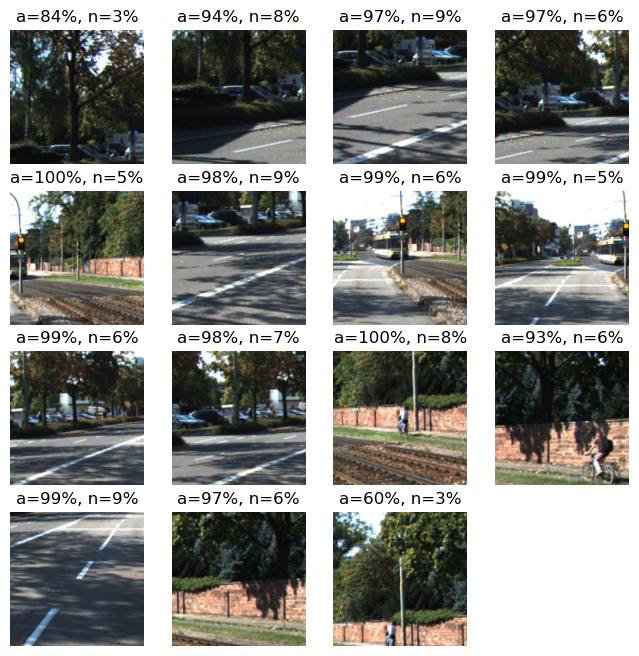

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

for i, row_axes in enumerate(axes):
    for j, ax in enumerate(row_axes):
        ax.axis('off')
        try:
            np_depth = depth_torch2np(depth[i*4 + j])
            np_pred = depth_torch2np(pred_depth[i*4 + j])
            metric = compute_metrics(np_pred, np_depth, 1e-3, 80.)
            ax.imshow(image_torch2np(image[i*4 + j]))
            ax.set_title(f"a={metric['a1']*100:.0f}%, n={(np_depth > 0).mean()*100:.0f}%")
        except IndexError:
            continue

In [16]:
image, depth = grid_set[4343]

pred_depth = model(image)

580.4140029367541
519.1970070115257
366.5596096980387
303.37020879283324
129.11184391544302
116.32972200311518
105.7175530888806
94.00983684388704
50.53391362441964
45.86809769867906
39.98277493349383
37.55471227189432
36.502239899873274
34.86123376182635
33.69335019834384
32.67002293049188
31.293555905505535
29.405371602091698
24.303131862216475
19.268786834552348
12.975522864312971
12.253177951848308
1.2596002856373638
0.7027336584505998


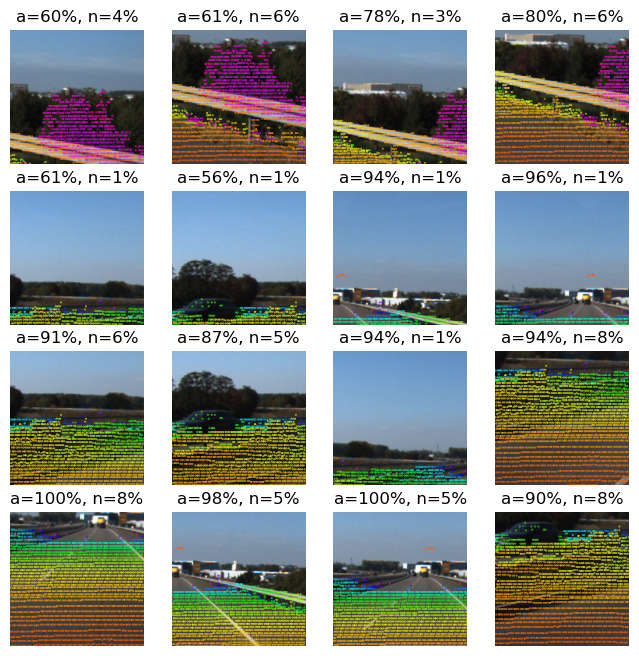

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

for i, row_axes in enumerate(axes):
    for j, ax in enumerate(row_axes):
        ax.axis('off')
        try:
            np_depth = depth_torch2np(depth[i*4 + j])
            np_pred = depth_torch2np(pred_depth[i*4 + j])
            metric = compute_metrics(np_pred, np_depth, 1e-3, 80.)
            
            valid = (depth_torch2np(depth[i*4 + j]) > 0)
            z = depth_torch2np(depth[i*4 + j])[valid]
            y, x = np.where(valid)
            ax.imshow(image_torch2np(image[i*4 + j]))
            #ax.imshow(image_torch2np(image[image.shape[0] - 1 - (i*4 + j)]))
            ax.set_title(f"a={metric['a1']*100:.0f}%, n={(np_depth > 0).mean()*100:.0f}%")
            ax.scatter(x, y, c=z, cmap='gist_rainbow', s=0.1, vmin=data_set.min_depth, vmax=data_set.max_depth)
        except IndexError:
            continue